In [279]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

from models.prepareData import getData, convertData, calcMinimumMaximum
from models.models import linearRegressionModel, PolynomialFeatures, lassoRegressionModel, ridgeRegressionModel
from models.models import RANSACRegressionModel, PolynomialRegressionModel

In [280]:
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Thọ', 'Phước Kiển', 'Nhà Bè')
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Cảnh', '22', 'Bình Thạnh')
# data = getData('Bán đất', 'Trần Văn Giàu', 'Lê Minh Xuân', 'Bình Chánh')
# data = getData('Bán đất', 'Vườn Lài', 'An Phú Đông', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán nhà riêng', 'Phạm Văn Chiêu', '9', 'Gò Vấp')
# data = getData('Bán nhà riêng', 'Nguyễn Văn Quá', 'Đông Hưng Thuận', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán đất', 'Nguyễn Thị Rành', 'Nhuận Đức', 'Củ Chi')
# data = getData('Bán đất', 'Tôn Đản', '10', '4')
# data = getData('Bán căn hộ chung cư', '9A', 'Bình Hưng', 'Bình Chánh')
data = getData('Bán nhà riêng', 'Cao Thắng', '12', '10')
# data = getData('Bán đất', 'Bà Thiên', 'Nhuận Đức', 'Củ Chi')
# data = getData('Bán nhà riêng', 'Số 8', 'Linh Xuân', 'Thủ Đức')

In [281]:
post_type = data['post_type'].iloc[0]
street = data['street'].iloc[0]
ward = data['ward'].iloc[0]
district = data['district'].iloc[0]

In [282]:
print("Data length: ", len(data))

Data length:  59


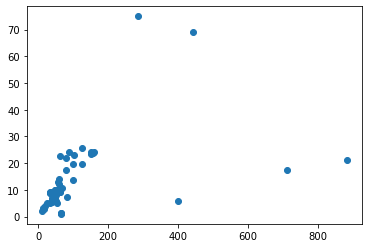

In [283]:
plt.scatter(data['area'], data['price'])
plt.show()

## Feature Engineering

### Clean data by observing dataset:

In [284]:
data = data[~(data['area'] < 10)]
data = data[~(data['price'] > 200)]

In [285]:
area_mean = np.mean(data['area'])
area_std = np.std(data['area'])

price_mean = np.mean(data['price'])
price_std = np.std(data['price'])

data = data[~( (data['area'] < area_mean) & (data['price'] > price_mean) )]
data = data[~( (data['area'] > area_mean) & (data['price'] < price_mean) )]

In [286]:
print("Area mean: ", area_mean)
print("Price mean: ", price_mean)

Area mean:  103.10508474576271
Price mean:  13.14681525423729


In [287]:
print("Data length: ", len(data))

Data length:  50


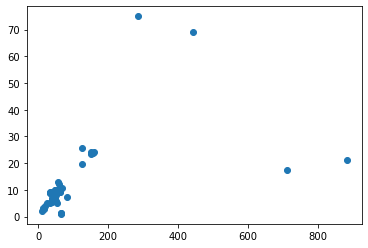

In [288]:
plt.scatter(data['area'], data['price'])
plt.show()

### Feature Scaling (both area & price)

In [289]:
# transform data into log1p
data['area'] = (data['area']).transform(np.log1p)
data['price'] = (data['price']).transform(np.log1p)

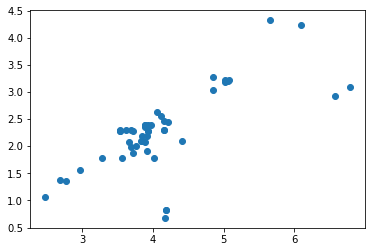

In [290]:
plt.scatter(data['area'], data['price'])
plt.show()

### Calculate mean of duplicated data

In [291]:
# Instead of drop duplicates try calc and use its mean value:
data = data.groupby(['area'], as_index=False).mean()

# sort data by area:
data = data.sort_values(by=['area'])

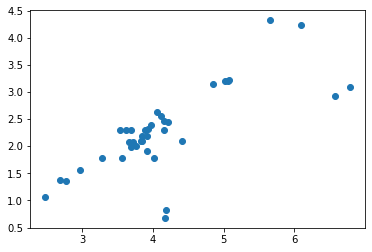

In [292]:
plt.scatter(data['area'], data['price'])
plt.show()

## RANSAC Algorithm in Detecting Outliers
- This method is not a good choice if the dataset not follow linear trends
- Beside, using a base estimator same with the current model will make this prediction in spoiled data => I assume that it is not a good practice

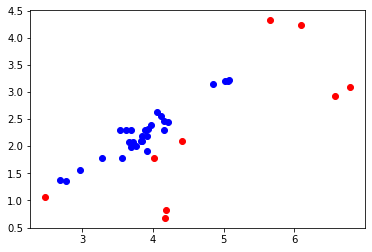

In [293]:
test_area, test_price = convertData(data)
ransac_model = RANSACRegressionModel(test_area, test_price, base_estimator=PolynomialRegressionModel(degree=5))
inlier_mask = ransac_model.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

plt.scatter(test_area[inlier_mask], test_price[inlier_mask], color='blue')
plt.scatter(test_area[outlier_mask], test_price[outlier_mask], color='red')
plt.show()

### Use IQR method to remove outliers

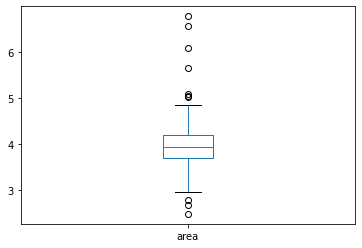

In [294]:
data['area'].plot(kind='box')
plt.show()

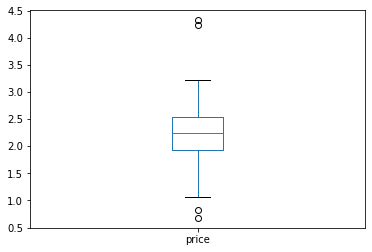

In [295]:
data['price'].plot(kind='box')
plt.show()

In [296]:
# # remove outliers using box-plot:
# while True:
#     area_minimum, area_maximum = calcMinimumMaximum(data['area'])
#     if (data['area'] > area_minimum).all() and (data['area'] < area_maximum).all():
#         break
#     else:
#         data = data[(data['area'] > area_minimum) & (data['area'] < area_maximum)]

# while True:
#     price_minimum, price_maximum = calcMinimumMaximum(data['price'])
#     if (data['price'] > price_minimum).all() and (data['price'] < price_maximum).all():
#         break
#     else:
#         data = data[(data['price'] > price_minimum) & (data['price'] < price_maximum)]

In [297]:
# area_minimum, area_maximum = calcMinimumMaximum(data['area'])
# data = data[(data['area'] > area_minimum) & (data['area'] < area_maximum)]

# price_minimum, price_maximum = calcMinimumMaximum(data['price'])
# data = data[(data['price'] > price_minimum) & (data['price'] < price_maximum)]

In [298]:
max_area = data['area'].max()
max_price = data['price'].max()

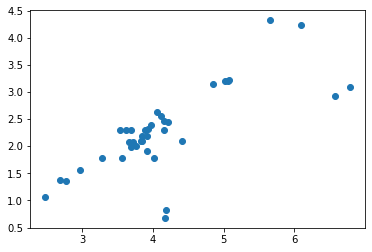

In [299]:
plt.scatter(data['area'], data['price'])
plt.show()

In [300]:
print("Data length: ", len(data))

Data length:  38


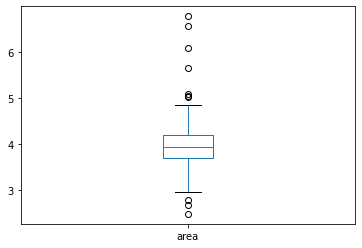

In [301]:
data['area'].plot(kind='box')
plt.show()

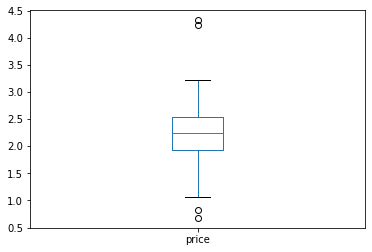

In [302]:
data['price'].plot(kind='box')
plt.show()

In [303]:
print("Data length: ", len(data))

Data length:  38


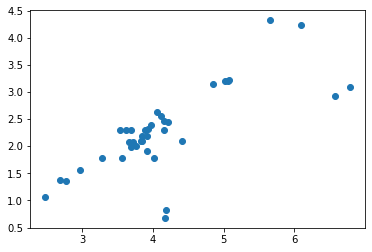

In [304]:
plt.scatter(data['area'], data['price'])
plt.show()

### Use Local Outlier Factor to remove _local outliers_

In [305]:
# from sklearn.neighbors import LocalOutlierFactor

# # convert dataframe into numpy array:
# X = data.to_numpy()
# n_neighbors = 8

In [306]:
# isNeighbors = LocalOutlierFactor(n_neighbors=n_neighbors, algorithm='brute', metric='euclidean', contamination=0.2).fit_predict(X)

# # locate outliers by index:
# outlier_indexes = np.where(isNeighbors == -1)
# outlier_values = data.iloc[outlier_indexes]

# # drop outliers:
# data = data.drop(outlier_values.index)

# print("\nOutliers detected by Local Outlier Factor with n_neighbors = ", n_neighbors)
# # plot outliers removed:
# plt.scatter(data['area'], data['price'], color='blue', label='inliers')
# plt.scatter(outlier_values['area'], outlier_values['price'], color='red', label='outliers')
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.tight_layout()
# plt.xlabel('area')
# plt.ylabel('price')
# plt.show()

### Split dataset
1. Train dataset: 70%
2. Validate dataset: 15%
3. Test dataset: 15%

In [307]:
# divide data into train and test:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=4)
test_data, validate_data = train_test_split(test_data, test_size=0.5, random_state=4)

In [308]:
# Sort data by area column:
train_data = train_data.sort_values(by=['area'])
test_data = test_data.sort_values(by=['area'])
validate_data = validate_data.sort_values(by=['area'])

print("\nTrain data length: ", len(train_data))
print("Test data length: ", len(test_data))
print("Validate data length: ", len(validate_data))


Train data length:  26
Test data length:  6
Validate data length:  6


### Visualize features relationship

In [309]:
# # convert data into numpy
X, Y = convertData(data)
X_train, Y_train = convertData(train_data)
X_test, Y_test = convertData(test_data)
X_validate, Y_validate = convertData(validate_data)

Text(0.5, 1.0, 'Y_validate')

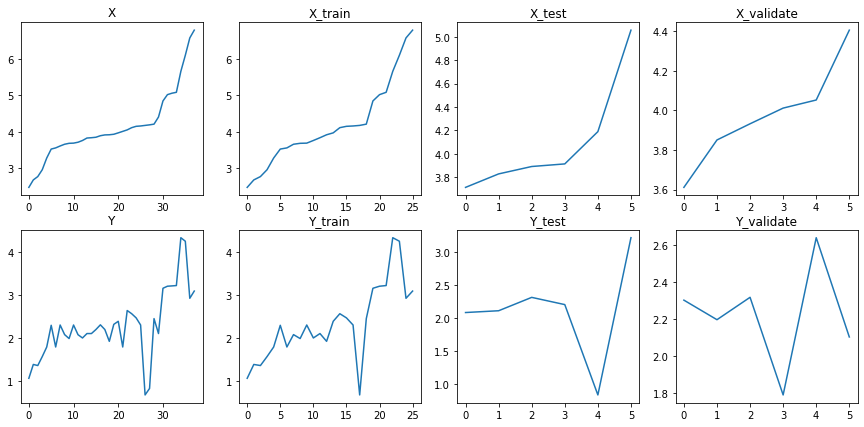

In [310]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0][0].plot(X)
ax[0][0].set_title('X')
ax[0][1].plot(X_train)
ax[0][1].set_title('X_train')
ax[0][2].plot(X_test)
ax[0][2].set_title('X_test')
ax[0][3].plot(X_validate)
ax[0][3].set_title('X_validate')

ax[1][0].plot(Y)
ax[1][0].set_title('Y')
ax[1][1].plot(Y_train)
ax[1][1].set_title('Y_train')
ax[1][2].plot(Y_test)
ax[1][2].set_title('Y_test')
ax[1][3].plot(Y_validate)
ax[1][3].set_title('Y_validate')

## Linear Regression Model

In [311]:
# find model by using linear regression:
linear_regression_model = linearRegressionModel(X_train, Y_train)

# find Y by using linear model predict:
Y_train_pred = linear_regression_model.predict(X_train)
Y_validate_pred = linear_regression_model.predict(X_validate)
Y_test_pred = linear_regression_model.predict(X_test)

# Calculate RMSE on train and test data:
train_linear_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
validate_linear_rmse = np.sqrt(mean_squared_error(Y_validate, Y_validate_pred))
test_linear_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))


Linear Regression Model: 


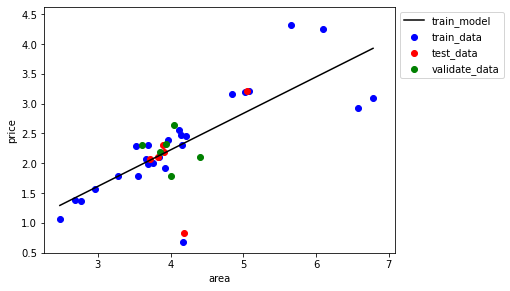

In [312]:
print("\nLinear Regression Model: ")
# Plot linear model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

In [313]:
# Linear Model coefficient and intercept:
print("Linear model coefficient: {}".format(linear_regression_model.coef_))
print("Linear model intercept: {}".format(linear_regression_model.intercept_))

# linear_model rmse:
print("Linear model rmse on train data: {}".format(train_linear_rmse))
print("Linear model rmse on validate data: {}".format(validate_linear_rmse))
print("Linear model rmse on test data: {}".format(test_linear_rmse))
print("\n\n")

Linear model coefficient: [[0.61268009]]
Linear model intercept: [-0.22576804]
Linear model rmse on train data: 0.5138106052035937
Linear model rmse on validate data: 0.31561432201838785
Linear model rmse on test data: 0.6359068462177145





In [314]:
def calcRMSE(model, X, Y):
    return np.sqrt(mean_squared_error(Y, model.predict(X)))

def calcCV(model, X, Y, scoring):
    return np.mean(cross_val_score(model, X, Y, scoring=scoring, cv=5))

## Polynomial Regression Model

In [315]:
def polynomialTransform(dataset, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    dataset_poly = polynomial_features.fit_transform(dataset)
    return dataset_poly

In [316]:
# degree = 2
X_train_poly = polynomialTransform(X_train, 2)
selected_poly_model = linearRegressionModel(X_train_poly, Y_train)

# calc rmse on validate data:
X_validate_poly = polynomialTransform(X_validate, 2)
min_poly_rmse = calcRMSE(selected_poly_model, X_validate_poly, Y_validate)

# Choose model with specific degree:
selected_degree = 2
selected_X_train_poly = X_train_poly

min_degree = 3
max_degree = 100

for i in range(min_degree, max_degree+1):
    X_train_poly = polynomialTransform(X_train, i)
    poly_model = linearRegressionModel(X_train_poly, Y_train)

    # calc rmse on validate data:
    X_validate_poly = polynomialTransform(X_validate, i)
    rmse = calcRMSE(poly_model, X_validate_poly, Y_validate)

    # Try to select the model with minimum rmse:
    if rmse < min_poly_rmse:
        min_poly_rmse = rmse
        selected_poly_model = poly_model
        selected_X_train_poly = X_train_poly
        selected_degree = i
        
print("Polynomial Regression with degree = ", selected_degree)
print("RMSE on validate data: ", min_poly_rmse)
print("Polynomial model coefficient:")
print(selected_poly_model.coef_)
print("Polynomial model intercept: {}\n".format(selected_poly_model.intercept_))

# Predict Y:
Y_train_poly_pred = selected_poly_model.predict(selected_X_train_poly)

Polynomial Regression with degree =  26
RMSE on validate data:  0.2790928705231734
Polynomial model coefficient:
[[ 3.78510801e-11 -1.37865342e-13  6.99960587e-15  2.41225156e-14
   9.40111460e-14  3.40749616e-13  1.17238528e-12  3.86375153e-12
   1.22368233e-11  3.72319309e-11  1.08497848e-10  3.01097207e-10
   7.88772806e-10  1.92537287e-09  4.29495525e-09  8.49202028e-09
   1.41146366e-08  1.76604479e-08  1.16078305e-08 -7.03750801e-09
  -1.55177500e-08  1.44817804e-08 -5.44684698e-09  1.11292836e-09
  -1.30167631e-10  8.22903995e-12 -2.18923534e-13]]
Polynomial model intercept: [1.25129346]



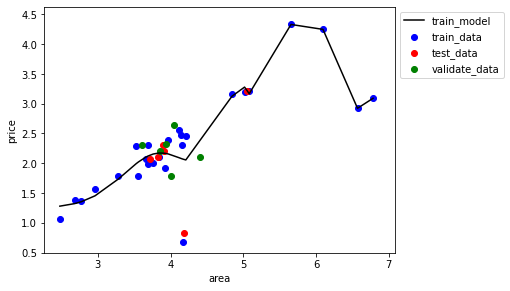

In [317]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_poly_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

### Alpha Hyperparameter

In [318]:
alphas = [0.00001, 0.00003, 0.00005, 0.00008, 0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.1, 1.0, 3.0, 5.0, 10.0, 50.0, 100.0]

In [319]:
X_validate_poly = polynomialTransform(X_validate, selected_degree)

In [320]:
# ignore warnings: =))) 
import warnings

## Ridge Regression Model

In [321]:
selected_ridge_alpha = alphas[0]
warnings.filterwarnings('ignore')

ridge_model = linear_model.Ridge(alpha=selected_ridge_alpha, fit_intercept=True, normalize=False, max_iter=2000, tol=0.001)
min_ridge_cv_score = calcCV(ridge_model, selected_X_train_poly, Y_train, 'neg_root_mean_squared_error')

for alpha in alphas[1:]:
    ridge_model = linear_model.Ridge(alpha=alpha, fit_intercept=True, normalize=False, max_iter=2000, tol=0.001)
    ridge_cv_score = calcCV(ridge_model, selected_X_train_poly, Y_train, 'neg_root_mean_squared_error')

    if ridge_cv_score < min_ridge_cv_score:
        min_ridge_cv_score = ridge_cv_score
        selected_ridge_alpha = alpha
        
# fit model with selected alpha:
ridge_model = ridgeRegressionModel(selected_X_train_poly, Y_train, selected_ridge_alpha)

# RMSE:
ridge_rmse = calcRMSE(ridge_model, X_validate_poly, Y_validate)

print("Ridge Regression with alpha = {} and RMSE = {}".format(selected_ridge_alpha, ridge_rmse))
print("Ridge Regression coefficient:")
print(ridge_model.coef_)
print("Ridge Regression intercept: ", ridge_model.intercept_)

# Predict Y with Ridge:
Y_train_ridge_pred = ridge_model.predict(selected_X_train_poly)

Ridge Regression with alpha = 1e-05 and RMSE = 0.35656526223430285
Ridge Regression coefficient:
[[ 0.00000000e+00  2.26191279e-29  1.91236889e-28  1.23440033e-27
   7.18486862e-27  3.96489083e-26  2.11819619e-25  1.10658736e-24
   5.68192750e-24  2.87447325e-23  1.43398692e-22  7.05263137e-22
   3.41576324e-21  1.62594364e-20  7.58510095e-20  3.45405363e-19
   1.52697569e-18  6.50358469e-18  2.63946258e-17  1.00395565e-16
   3.48421541e-16  1.05152017e-15  2.49100534e-15  3.37306524e-15
  -1.92722291e-15  3.14041429e-16 -1.64722283e-17]]
Ridge Regression intercept:  [1.95260216]


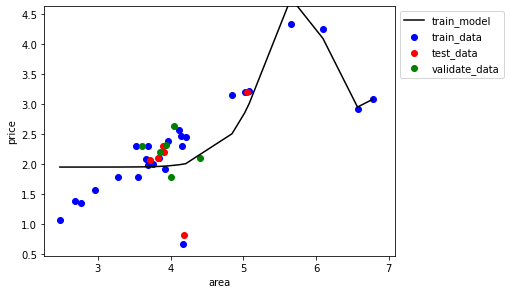

In [322]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_ridge_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

## Lasso Regression Model

In [323]:
selected_lasso_alpha = alphas[0]
warnings.filterwarnings('ignore')

lasso_model = linear_model.Lasso(alpha=selected_lasso_alpha, fit_intercept=True, normalize=True, max_iter=2000, tol=0.001)
min_lasso_cv_score = calcCV(lasso_model, selected_X_train_poly, Y_train, 'neg_root_mean_squared_error')

for alpha in alphas[1:]:
    lasso_model = linear_model.Lasso(alpha=alpha, fit_intercept=True, normalize=True, max_iter=2000, tol=0.001)
    lasso_cv_score = calcCV(lasso_model, selected_X_train_poly, Y_train, 'neg_root_mean_squared_error')

    if lasso_cv_score < min_lasso_cv_score:
        min_lasso_cv_score = lasso_cv_score
        selected_lasso_alpha = alpha
        
# Fit model with selected alpha:
lasso_model = lassoRegressionModel(selected_X_train_poly, Y_train, selected_lasso_alpha)
lasso_rmse = calcRMSE(lasso_model, X_validate_poly, Y_validate)

print("Lasso Model with alpha = {} and RMSE = {}".format(selected_lasso_alpha, lasso_rmse))
print("Lasso Regression coefficient:")
print(lasso_model.coef_)
print("Lasso Regression intercept: ", lasso_model.intercept_)

# Predict Y with Ridge:
Y_train_lasso_pred = lasso_model.predict(selected_X_train_poly)

Lasso Model with alpha = 5e-05 and RMSE = 0.3573400827081331
Lasso Regression coefficient:
[ 0.00000000e+00  1.78681220e+00 -3.00240396e-01 -2.12791742e-03
  2.33889787e-03  4.26267682e-04  5.08212623e-05  4.34547835e-06
  1.66544057e-07 -3.28182651e-08 -1.07553993e-08 -2.09254807e-09
 -3.38093397e-10 -4.91471809e-11 -6.61894950e-12 -8.33531371e-13
 -9.76815769e-14 -1.04012658e-14 -9.37103233e-16 -5.27484230e-17
  4.11647629e-18  2.22877444e-18  5.46167155e-19  1.09316721e-19
  1.98826081e-20  3.41849711e-21  5.66350916e-22]
Lasso Regression intercept:  [-1.35653607]


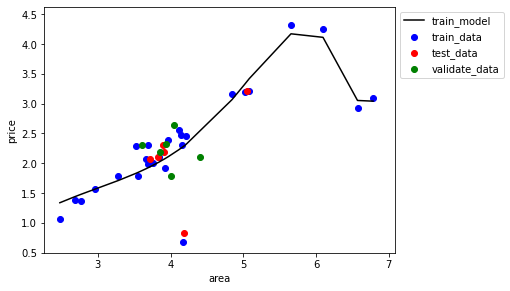

In [324]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_lasso_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.xlim(right=max_area+0.3)
plt.ylim(top=max_price+0.3)
plt.show()

In [325]:
# score the model with test data:
X_test_poly = polynomialTransform(X_test, selected_degree)

# Linear score:
print("\n")

linear_train_r2_score = linear_regression_model.score(X_train, Y_train)
print("Linear Model score on train dataset: ", linear_train_r2_score)

linear_test_r2_score = linear_regression_model.score(X_test, Y_test)
print("Linear Model score on test dataset: ", linear_test_r2_score)

# Poly score:
print("\n")

poly_train_r2_score = selected_poly_model.score(selected_X_train_poly, Y_train)
print("Poly Model score on train dataset: ", poly_train_r2_score)

poly_test_r2_score = selected_poly_model.score(X_test_poly, Y_test)
print("Poly Model score on test dataset: ", poly_test_r2_score)

# Ridge score:
print("\n")

ridge_train_r2_score = ridge_model.score(selected_X_train_poly, Y_train)
print("Ridge Model score on train dataset: ", ridge_train_r2_score)

ridge_test_r2_score = ridge_model.score(X_test_poly, Y_test)
print("Ridge Model score on test dataset: ", ridge_test_r2_score)

# Lasso score:
print("\n")

lasso_train_r2_score = lasso_model.score(selected_X_train_poly, Y_train)
print("Lasso Model score on train dataset: ", lasso_train_r2_score)

lasso_test_r2_score = lasso_model.score(X_test_poly, Y_test)
print("Lasso Model score on test dataset: ", lasso_test_r2_score)



Linear Model score on train dataset:  0.6342882458006287
Linear Model score on test dataset:  0.16355946538587818


Poly Model score on train dataset:  0.8440408184013778
Poly Model score on test dataset:  0.4664162020339935


Ridge Model score on train dataset:  0.7069808347378439
Ridge Model score on test dataset:  0.4289222348481877


Lasso Model score on train dataset:  0.814864444247865
Lasso Model score on test dataset:  0.2116375739686408


In [326]:
# # calc cross validation score of linear to compare with poly for best model selection
# linear_cv = np.mean(cross_val_score(linear_model, X, Y, cv=5))
# poly_cv = np.mean(cross_val_score(poly_model, X, Y, cv=5))

# best_r2_score = linear_test_r2_score if linear_test_r2_score > poly_test_r2_score else poly_test_r2_score
# best_model = linear_model if linear_cv > poly_cv else poly_model
# best_degree = 1 if linear_cv > poly_cv else degree

# print(linear_cv)
# print(poly_cv)

In [327]:
import unidecode
post_type = unidecode.unidecode(post_type.lower().replace(" ", ""))
street = unidecode.unidecode(street.lower().replace(" ", ""))
ward = unidecode.unidecode(ward.lower().replace(" ", ""))
district = unidecode.unidecode(district.lower().replace(" ", ""))
model_name = post_type + "_" + street + "_" + ward + "_" + district

In [328]:
model_name

'bannharieng_caothang_12_10'

In [329]:
# # Save model after training for later use:
# from joblib import dump, load

# if best_r2_score > 0.7:
#     # Save model:
#     dump((best_model, best_degree), 'trained\\' + model_name + '.joblib')

In [330]:
# try:    
#     # load model:
#     loaded_model, loaded_degree = load('trained/' + model_name + ".joblib")

#     test_area = np.array([92.00])
#     test_area = test_area[:, np.newaxis]
#     test_area = FunctionTransformer(np.log1p).fit_transform(test_area)

#     if loaded_degree == 1:
#         predicted_price = loaded_model.predict(test_area)
#     else:
#         test_area_poly = PolynomialFeatures(degree=loaded_degree).fit_transform(test_area)
#         predicted_price = loaded_model.predict(test_area_poly)

#     print(FunctionTransformer(np.log1p).inverse_transform(predicted_price))
# except FileNotFoundError:
#     print("Model not found or trained result is low!")